In [308]:
"""This module saves different visualizations in bld / figures."""

'This module saves different visualizations in bld / figures.'

In [309]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from frechet_fda.config import SRC, BLD
from frechet_fda.tools.data_generation_tools import (
    make_truncnorm_pdf,
    gen_params_scenario_one,
)
from frechet_fda.tools.fda_tools import (
    compute_mean_and_centered_data,
    compute_cov_function,
    compute_principal_components,
    mode_of_variation,
    gen_qdtransformation_pcs,
    karhunen_loeve
)
from frechet_fda.tools.function_tools import (
    get_optimal_range,
    frechet_mean,
    make_function_objects,
    log_qd_transform,
    inverse_log_qd_transform
)


# Load saved results from simulations

In [310]:
# Save the dictionary using pickle
fda_path_pickle = SRC / "sim_results" / "stored_fda_arrays.pkl"
frechet_path_pickle = SRC / "sim_results" / "stored_ise_arrays.pkl"

with open(fda_path_pickle, "rb") as handle:
    means_and_kh_dict = pickle.load(handle)
with open(frechet_path_pickle, "rb") as handle:
    ise = pickle.load(handle)

# FDA plots

## Set up directories where to save figures

In [311]:
directories = {
    "frechet_means" : BLD / "figures" / "frechet_means.pgf",
    "comparison_f_cs": BLD / "figures" / "comparison_f_cs.pgf",
    "f_mean_vs_denstimation" : BLD / "figures" / "f_mean_vs_denstimation.pgf",
    "cs_mean_vs_denstimation" : BLD / "figures" / "cs_mean_vs_denstimation.pgf",
    "k_opt_histogram" : BLD / "figures" / "k_opt_histogram.pgf",
    "k_opt_denstimation_histogram" : BLD / "figures" / "k_opt_denstimation_histogram.pgf",
    "fve" : BLD / "figures" / "fve.pgf",
    "fve_denstimation" : BLD / "figures" / "fve_denstimation.pgf",
}
for filepath in directories.values():
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)

## Some examples for FDA methods with densities

In [312]:
# Set parameters
test_n = 200
test_grid_size = 2000
test_trunc = 3
test_seed = 28071995
test_mus, test_sigmas = gen_params_scenario_one(test_n, seed=test_seed)
# Sort sigmas just for inspection reasons
test_sigmas.sort()

In [313]:
# Generate pdfs within truncation points
test_pdfs = make_truncnorm_pdf(
    -test_trunc, test_trunc, test_mus, test_sigmas, grid_size=test_grid_size, warn_irregular_densities=False
)
# Make lists of Function class objects
test_my_pdfs = make_function_objects(test_pdfs)
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
test_new_ranges = get_optimal_range(test_my_pdfs)
# Generate pdfs again, this time within individual ranges
test_pdfs2 = [
    make_truncnorm_pdf(
        test_new_ranges[i][0],
        test_new_ranges[i][1],
        test_mus[i],
        test_sigmas[i],
        grid_size=test_grid_size,
        warn_irregular_densities=False,
    )[0]
    for i in range(test_n)
]

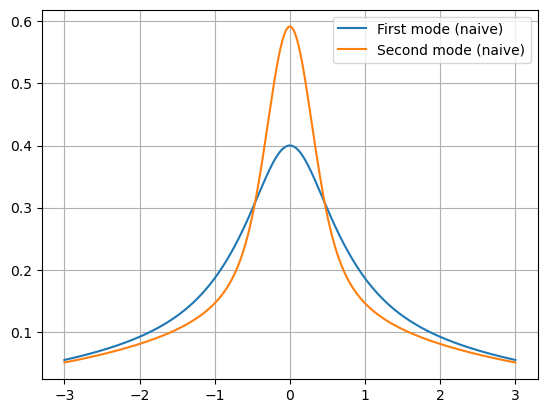

In [314]:
test_new_pdfs = make_function_objects(test_pdfs2)
naive_mean_pdf, test_centered_pdfs = compute_mean_and_centered_data(test_new_pdfs)
test_covariance_function = compute_cov_function(test_centered_pdfs)
naive_eigenvalues, naive_eigenfunctions = compute_principal_components(
    test_centered_pdfs[0].x,
    test_covariance_function,
)
naive_mode_of_variation1 = mode_of_variation(
    naive_mean_pdf, naive_eigenvalues[0], naive_eigenfunctions[0], 1
)
naive_mode_of_variation2 = mode_of_variation(
    naive_mean_pdf, naive_eigenvalues[1], naive_eigenfunctions[1], 1
)
naive_mode_of_variation1.compare(
    naive_mode_of_variation2,
    label_self = "First mode (naive)",
    label_other = "Second mode (naive)"
)

### Transformation FPCA

In [315]:
test_log_qdfs = log_qd_transform(test_new_pdfs)
# Compute transformation FPCA objects
test_pcs_to_compute = 15
(
    test_mean_log_qdfs,
    test_eigenvalues_log_qdfs,
    test_eigenfunctions_log_qdfs,
    test_fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(test_log_qdfs, k=test_pcs_to_compute)

In [316]:
# Karhunen-Loève decomposition of transforms
test_truncation_k = 2
test_truncated_representations_transforms = karhunen_loeve(
    test_mean_log_qdfs,
    test_eigenfunctions_log_qdfs,
    test_fpc_scores_log_qdfs,
    K=test_truncation_k,
)

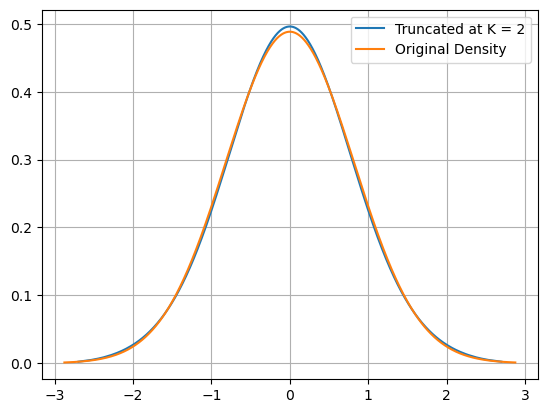

<Figure size 640x480 with 0 Axes>

In [317]:
# Transform to density space. Compare truncated representation against real density
test_pdf_of_interest = 90
test_truncated_representations = inverse_log_qd_transform(
    test_truncated_representations_transforms,
)
test_truncated_representations[test_pdf_of_interest].compare(
    test_new_pdfs[test_pdf_of_interest],
    label_self=f"Truncated at K = {test_truncation_k}",
    label_other="Original Density",
)
# Save the figure
plt.savefig(directories["Truncated representation of density"], format='pgf', dpi=1200)


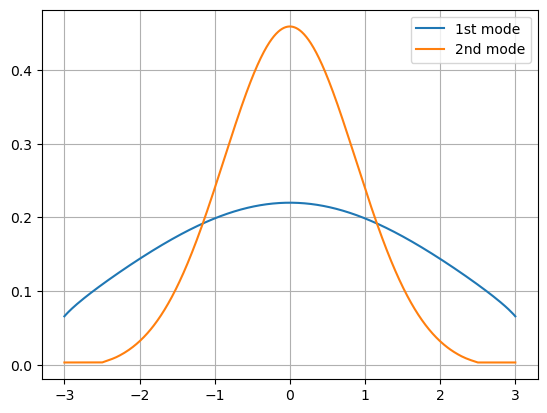

In [148]:
# Modes of variation
test_variation_modes_transforms = [
    mode_of_variation(test_mean_log_qdfs, eigval, eigfunc, alpha=1)
    for eigval, eigfunc
    in zip(test_eigenvalues_log_qdfs, test_eigenfunctions_log_qdfs, strict=True)
]
# Translate modes of variation to density space, compare first two modes
test_variation_modes = inverse_log_qd_transform(test_variation_modes_transforms)
test_variation_modes[0].warp_range(-test_trunc, test_trunc).compare(
    test_variation_modes[1].warp_range(-test_trunc, test_trunc),
    label_self="1st mode",
    label_other="2nd mode",
)

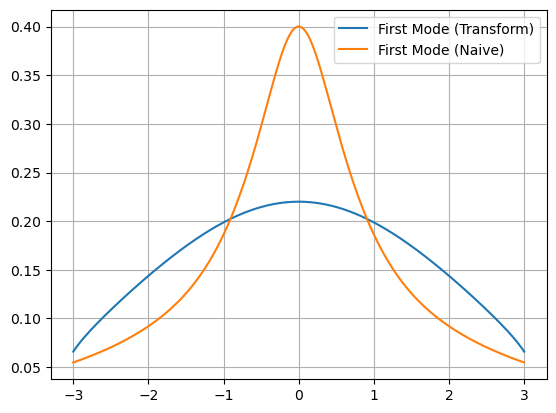

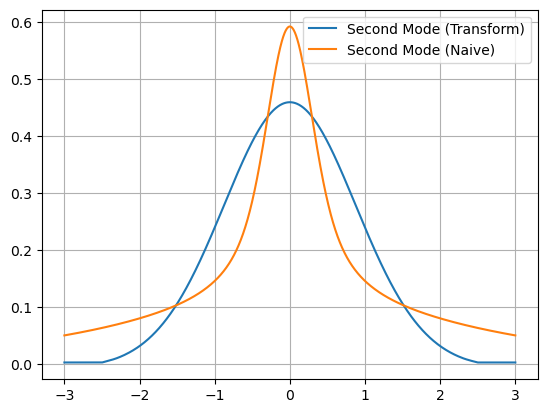

In [149]:
test_variation_modes[0].warp_range(-test_trunc, test_trunc).compare(
    naive_mode_of_variation1,
    label_self="First Mode (Transform)",
    label_other="First Mode (Naive)",
)
test_variation_modes[1].warp_range(-test_trunc, test_trunc).compare(
    naive_mode_of_variation2,
    label_self="Second Mode (Transform)",
    label_other="Second Mode (Naive)",
)

## Load simulation parameters

In [87]:
# Number of simulations
m = 500
# Number of samples of densities to generate
sample_sizes = [50, 100, 200]
# Number of sample points to generate from each density for density estimation step
points_number = 100
# Bandwidth choice for density estimation
bandwidth_choice = 0.2
# Fineness of grids to evaluate functions
grid_size = 1000
# Where to truncate normal distribution
trunc = 3
# Choose how many FPCS to compute. Maximum: grid_size
how_many_fpcs = 10
# How much variance to be explained for cutoff in KH-representation
threshold_variance_explained = 0.9
# Whether to compute Wasserstein-Fréchet means artifically centered on zero
centered_on_zero = False

In [88]:
# Calculate true center of distribution for plotting against estimates
std_normal = make_truncnorm_pdf(-trunc, trunc, 0, 1, grid_size=grid_size)[0]

In [89]:
stored_f_means = means_and_kh_dict["stored_means_frechet"]
stored_cs_means = means_and_kh_dict["stored_means_cs"]
stored_f_means_denstimation = means_and_kh_dict["stored_means_frechet_denstimation"]
stored_cs_means_denstimation = means_and_kh_dict["stored_means_cs_denstimation"]

stored_k_opt = means_and_kh_dict["stored_k_opt"]
stored_fve = means_and_kh_dict["stored_fve"]
stored_k_opt_denstimation = means_and_kh_dict["stored_k_opt_denstimation"]
stored_fve_denstimation = means_and_kh_dict["stored_fve_denstimation"]

In [90]:
# Calculate Fréchet means of Fréchet means over all simulations; standardize their range
# to [-3,3] by linear interpolation because uncertatinty from estimation of support
# start leads them out of support
mean_of_f_means50 = frechet_mean(stored_f_means[:, 0], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_f_means100 = frechet_mean(stored_f_means[:, 1], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_f_means200 = frechet_mean(stored_f_means[:, 2], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_cs_means50 = frechet_mean(stored_cs_means[:, 0], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_cs_means100 = frechet_mean(stored_cs_means[:, 1], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_cs_means200 = frechet_mean(stored_cs_means[:, 2], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_f_means50_denstimation = frechet_mean(stored_f_means_denstimation[:, 0], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_f_means100_denstimation = frechet_mean(stored_f_means_denstimation[:, 1], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_f_means200_denstimation = frechet_mean(stored_f_means_denstimation[:, 2], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_cs_means50_denstimation = frechet_mean(stored_cs_means_denstimation[:, 0], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_cs_means100_denstimation = frechet_mean(stored_cs_means_denstimation[:, 1], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)
mean_of_cs_means200_denstimation = frechet_mean(stored_cs_means_denstimation[:, 2], centered_on_zero=centered_on_zero).warp_range(-trunc, trunc)

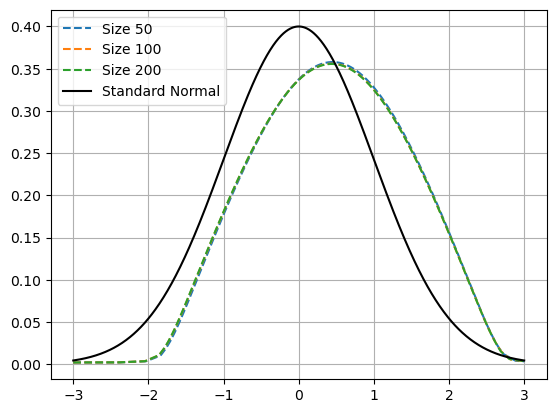

In [91]:
# Plot Fréchet means of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(mean_of_f_means50.x, mean_of_f_means50.y, label="Size 50", linestyle="--")
ax.plot(mean_of_f_means100.x, mean_of_f_means100.y, label="Size 100", linestyle="--")
ax.plot(mean_of_f_means200.x, mean_of_f_means200.y, label="Size 200", linestyle="--")
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["frechet_means"], format='pgf', dpi=1200)
# Show it
plt.show()

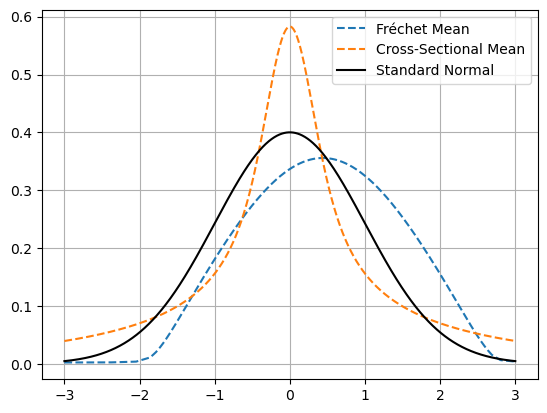

In [92]:
# Plot Fréchet mean vs cross-sectional mean and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x, mean_of_f_means200.y, label="Fréchet Mean", linestyle="--",
)
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="Cross-Sectional Mean",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["comparison_f_cs"], format='pgf', dpi=1200)
# Show it
plt.show()

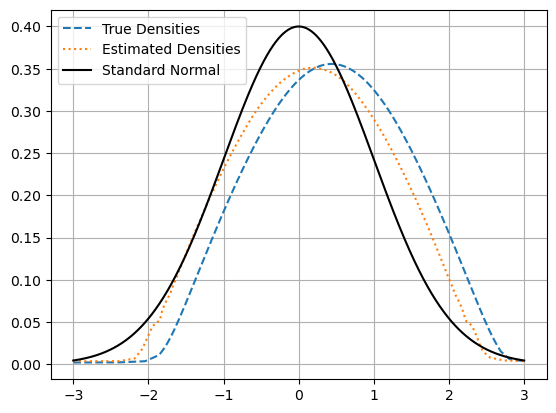

In [93]:
# Plot Fréchet mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x,
    mean_of_f_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="dotted",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["f_mean_vs_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()

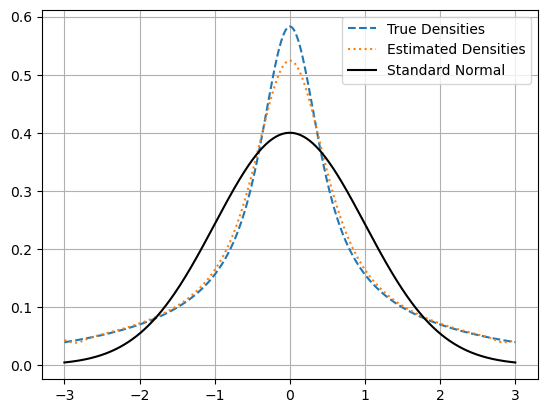

In [94]:
# Plot cross-sectional mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_cs_means200_denstimation.x,
    mean_of_cs_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="dotted",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["cs_mean_vs_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()

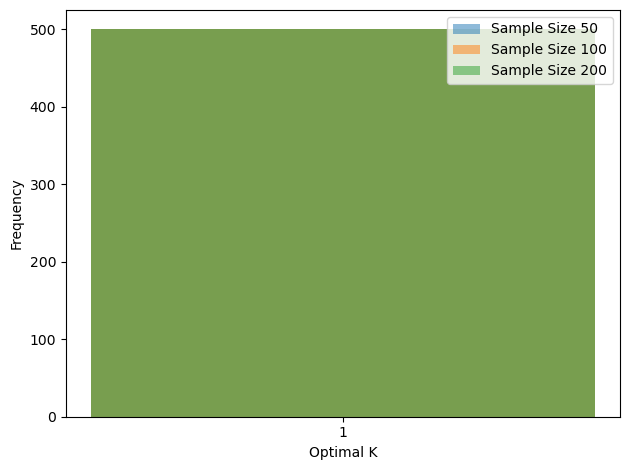

In [95]:
data_of_interest = stored_k_opt

plt.subplot()

# Create histograms
for j in range(len(sample_sizes)):
    plt.hist(data_of_interest[:, j], bins=np.arange(0.5, np.max(data_of_interest) + 1.5), alpha=0.5, label=f"Sample Size {sample_sizes[j]}")

# Set x-axis ticks to represent each positive integer up to the maximum value of K
plt.xticks(np.arange(1, np.max(data_of_interest) + 1))

plt.xlabel("Optimal K")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig(directories["k_opt_histogram"], format='pgf', dpi=1200)
# Show it
plt.show()

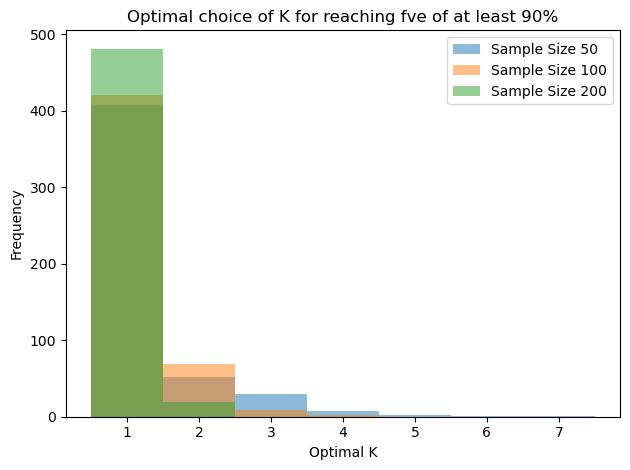

In [96]:
data_of_interest = stored_k_opt_denstimation

plt.subplot()

# Create histograms
for j in range(len(sample_sizes)):
    plt.hist(data_of_interest[:, j], bins=np.arange(0.5, np.max(data_of_interest) + 1.5), alpha=0.5, label=f"Sample Size {sample_sizes[j]}")

# Set x-axis ticks to represent each positive integer up to the maximum value of K
plt.xticks(np.arange(1, np.max(data_of_interest) + 1))

plt.title("Optimal choice of K for reaching fve of at least 90%")
plt.xlabel("Optimal K")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig(directories["k_opt_denstimation_histogram"], format='pgf', dpi=1200)
# Show it
plt.show()

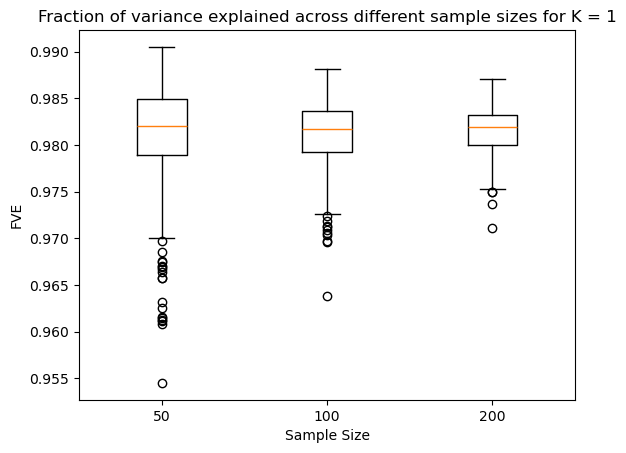

In [97]:
plt.boxplot(stored_fve, labels=["50", "100", "200"])

plt.title("Fraction of variance explained across different sample sizes for K = 1")
plt.xlabel("Sample Size")
plt.ylabel("FVE")

# Save the figure
plt.savefig(directories["fve"], format='pgf', dpi=1200)
# Show it
plt.show()

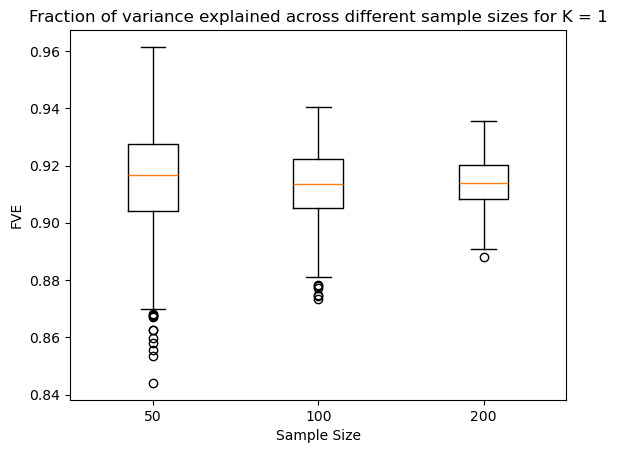

In [98]:
plt.boxplot(stored_fve_denstimation, labels=["50", "100", "200"])

plt.title("Fraction of variance explained across different sample sizes for K = 1")
plt.xlabel("Sample Size")
plt.ylabel("FVE")

# Save the figure
plt.savefig(directories["fve_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()